# Pre-requisites  
- download dataset.zip,  
- unzip dataset,    
- mount drive,  

In [ ]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
    !pip install gdown
    !pip3 install pillow==8.2
    !pip install neptune-client
    !pip install neptune-client neptune-tensorboard
    !pip install neptune-contrib
    !pip install mxnet
    !pip install git+https://github.com/lucasb-eyer/pydensecrf.git
    !pip install tensorboardX

In [ ]:
# Download VOC2012
# !gdown https://drive.google.com/uc?id=1PDTEuTnWJZNWogxYdqYGOlEZHK8dYET9

# Download custom Kvasir-v2
# ! gdown https://drive.google.com/uc?id=1WG5F7VVQe6mNupR1LLirkG_Apx6Bup5J

In [ ]:
# with io.capture_output() as captured:
#   # !unzip -q VOC2012.zip
#   !unzip -q Kvasir-v2.zip
#   # !rm -rf VOC2012.zip
#   !rm -rf Kvasir-v2.zip

In [ ]:
import neptune
from neptunecontrib.monitoring.keras import NeptuneMonitor
from IPython.utils import io
# connect run to project
NEPTUNE_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMGUxMmQ1NC00ZDU4LTQ4ZGYtOWJjOC0xYTJkYjJmYmJiZDMifQ=='
run = neptune.init(project_qualified_name='ch.kalavritinos/SEAM', api_token=NEPTUNE_TOKEN)

In [ ]:
with io.capture_output() as captured:
  from google.colab import drive 
  drive.mount('/content/drive')
%cd /content/drive/MyDrive/MAI/thesis/source

/content/drive/MyDrive/MAI/thesis/source


# SEAM train
Imports

Change directory to SEAM




In [ ]:
%cd SEAM/

/content/drive/MyDrive/MAI/thesis/source/SEAM


In [ ]:
import sys
import numpy as np
import torch
import random
import cv2
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from utils import pyutils, imutils, torchutils
import argparse
import importlib
import torch.nn.functional as F

# PARAMETERS

In [ ]:
root_dir = 'OAA'
data_root = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/'   # dataset directory
train_list = 'kvasirv2/train.txt'           # list of train images
test_list = 'kvasirv2/val.txt'              # list of val images
snapshot_dir = 'checkpoints/train/exp4/'    # where to save models
att_dir = './results_kvasir/exp4/attention/'   # where to save attentions
dataset = 'kvasir-v2'                       # dataset used
network="network.resnet38_SEAM"

epoch = 14
lr = 0.001
batch_size = 2
input_size = 256
disp_interval = 100
num_classes = 20
num_workers = 8
weight_decay = 0.0005
decay_points = '5,10'

crop_size = 448         # for cropping images
threshold = 0.6         # for probabilities
disp_interval = 100     # display interval
resume  = False        # resume training 
global_counter = 0      
current_epoch = 0       # number of current epoch for resuming

# data.py  
for Kvasir-v2

In [ ]:
IMG_FOLDER_NAME = "polyps/"
ANNOT_FOLDER_NAME = "polyps/masks"

CAT_LIST = ['dyed-lifted-polyp',
            'dyed-resection-margins',
            'esophagitis',
            'normal-cecum',
            'normal-pylorus',
            'normal-z-line', 
            'polyps',
            'ulcerative-colitis']

CAT_NAME_TO_NUM = dict(zip(CAT_LIST,range(len(CAT_LIST))))


def load_image_label_list_from_npy(img_name_list):
    cls_labels_dict = np.load('kvasirv2/cls_labels.npy', allow_pickle=True).item()
    # print(cls_labels_dict)
    return [cls_labels_dict[img_name] for img_name in img_name_list]

def get_img_path(img_name, dataset_root):
    return os.path.join(dataset_root, img_name)

def load_img_name_list(dataset_path):
    img_gt_name_list = open(dataset_path).read().splitlines()
    img_name_list = [img_gt_name.split(' ')[0][-40:-4] for img_gt_name in img_gt_name_list]
    folder_paths_list = [img_gt_name.split(' ')[0] for img_gt_name in img_gt_name_list]
    return img_name_list, folder_paths_list

def load_label_list(dataset_path):
    zero_array = np.zeros(8, dtype=np.float32)
    list_of_arrays = []
    for i in range(8):
        z = np.zeros(8, dtype=np.float32)
        z[i]=1.0
        list_of_arrays.append(z)
    #print(list_of_arrays)
    img_name_list = open(dataset_path).read().splitlines()
    label_list = [list_of_arrays[int(img_name[-1:])-1] for img_name in img_name_list]
    return label_list

class KvasirImageDataset(Dataset):
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        self.img_name_list, self.folder_paths_list = load_img_name_list(img_name_list_path)
        self.dataset_root = dataset_root
        self.transform = transform

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        path = self.folder_paths_list[idx]
        #print(get_img_path(path, self.dataset_root))
        img = PIL.Image.open(get_img_path(path, self.dataset_root)).convert("RGB")
        # img = torch.from_numpy(np.array(img))

        if self.transform:
            img = self.transform(img)
        return name, img

class KvasirClsDataset(KvasirImageDataset):           # inherit init from previous class
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        super().__init__(img_name_list_path, dataset_root, transform)
        self.label_list = load_image_label_list_from_npy(self.img_name_list)        # get list from .npy file
        #self.label_list = load_image_label_list_from_xml(self.img_name_list, self.dataset_root)

    def __getitem__(self, idx):
        name, img = super().__getitem__(idx)
        label = torch.from_numpy(self.label_list[idx])
        return name, img, label

class KvasirClsDatasetMSF(KvasirClsDataset):
    def __init__(self, img_name_list_path, data_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, data_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)
        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        msf_img_list = []
        for i in range(len(ms_img_list)):
            msf_img_list.append(ms_img_list[i])
            msf_img_list.append(np.flip(ms_img_list[i], -1).copy())
        return name, msf_img_list, label

class KvasirClsDatasetMS(KvasirClsDataset):
    def __init__(self, img_name_list_path, dataset_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, dataset_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)
        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))
        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        return name, ms_img_list, label

# imutils.py


In [ ]:
import PIL.Image
import random
import numpy as np

class RandomResizeLong():
    """Resizes images from dataset using PIL to random shape between min_long and max_long"""
    def __init__(self, min_long, max_long):
        self.min_long = min_long
        self.max_long = max_long

    def __call__(self, img, sal=None):
        target_long = random.randint(self.min_long, self.max_long)
        w, h = img.size

        if w < h:
            target_shape = (int(round(w * target_long / h)), target_long)
        else:
            target_shape = (target_long, int(round(h * target_long / w)))

        img = img.resize(target_shape, resample=PIL.Image.CUBIC)
        if sal:
           sal = sal.resize(target_shape, resample=PIL.Image.CUBIC)
           return img, sal
        return img


class RandomCrop():
    """Randomly crops images"""
    def __init__(self, cropsize):
        self.cropsize = cropsize

    def __call__(self, imgarr, sal=None):
        imgarr = np.array(imgarr)
        h, w = imgarr.shape[0], imgarr.shape[1]                  # height, width

        ch = min(self.cropsize, h)
        cw = min(self.cropsize, w)

        w_space = w - self.cropsize
        h_space = h - self.cropsize

        if w_space > 0:
            cont_left = 0
            img_left = random.randrange(w_space+1)
        else:
            cont_left = random.randrange(-w_space+1)
            img_left = 0

        if h_space > 0:
            cont_top = 0
            img_top = random.randrange(h_space+1)
        else:
            cont_top = random.randrange(-h_space+1)
            img_top = 0

        container = np.zeros((self.cropsize, self.cropsize, np.shape(imgarr)[-1]), np.float32)
        container[cont_top:cont_top+ch, cont_left:cont_left+cw] = \
            imgarr[img_top:img_top+ch, img_left:img_left+cw]
        if sal is not None:
            container_sal = np.zeros((self.cropsize, self.cropsize,1), np.float32)
            container_sal[cont_top:cont_top+ch, cont_left:cont_left+cw,0] = \
                sal[img_top:img_top+ch, img_left:img_left+cw]
            return container, container_sal

        return container

def get_random_crop_box(imgsize, cropsize):
    h, w = imgsize

    ch = min(cropsize, h)
    cw = min(cropsize, w)

    w_space = w - cropsize
    h_space = h - cropsize

    if w_space > 0:
        cont_left = 0
        img_left = random.randrange(w_space + 1)
    else:
        cont_left = random.randrange(-w_space + 1)
        img_left = 0

    if h_space > 0:
        cont_top = 0
        img_top = random.randrange(h_space + 1)
    else:
        cont_top = random.randrange(-h_space + 1)
        img_top = 0

    return cont_top, cont_top+ch, cont_left, cont_left+cw, img_top, img_top+ch, img_left, img_left+cw

def crop_with_box(img, box):
    if len(img.shape) == 3:
        img_cont = np.zeros((max(box[1]-box[0], box[4]-box[5]), max(box[3]-box[2], box[7]-box[6]), img.shape[-1]), dtype=img.dtype)
    else:
        img_cont = np.zeros((max(box[1] - box[0], box[4] - box[5]), max(box[3] - box[2], box[7] - box[6])), dtype=img.dtype)
    img_cont[box[0]:box[1], box[2]:box[3]] = img[box[4]:box[5], box[6]:box[7]]
    return img_cont


def random_crop(images, cropsize, fills):
    if isinstance(images[0], PIL.Image.Image):
        imgsize = images[0].size[::-1]
    else:
        imgsize = images[0].shape[:2]
    box = get_random_crop_box(imgsize, cropsize)

    new_images = []
    for img, f in zip(images, fills):

        if isinstance(img, PIL.Image.Image):
            img = img.crop((box[6], box[4], box[7], box[5]))
            cont = PIL.Image.new(img.mode, (cropsize, cropsize))
            cont.paste(img, (box[2], box[0]))
            new_images.append(cont)

        else:
            if len(img.shape) == 3:
                cont = np.ones((cropsize, cropsize, img.shape[2]), img.dtype)*f
            else:
                cont = np.ones((cropsize, cropsize), img.dtype)*f
            cont[box[0]:box[1], box[2]:box[3]] = img[box[4]:box[5], box[6]:box[7]]
            new_images.append(cont)

    return new_images


class AvgPool2d():
    """Average pooling on 2d"""
    def __init__(self, ksize):
        self.ksize = ksize

    def __call__(self, img):
        import skimage.measure

        return skimage.measure.block_reduce(img, (self.ksize, self.ksize, 1), np.mean)


class RandomHorizontalFlip():
    """Randomly mirror images"""
    def __init__(self):
        return

    def __call__(self, img, sal=None):
        if bool(random.getrandbits(1)):
            #img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            img = np.fliplr(img).copy()
            if sal:
                #sal = sal.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                sal = np.fliplr(sal).copy()
                return img, sal 
            return img
        else:
            if sal:
                return img, sal
            return img


class CenterCrop():
    """Crop images centered"""
    def __init__(self, cropsize, default_value=0):
        self.cropsize = cropsize
        self.default_value = default_value

    def __call__(self, npimg):
        h, w = npimg.shape[:2]

        ch = min(self.cropsize, h)
        cw = min(self.cropsize, w)

        sh = h - self.cropsize
        sw = w - self.cropsize

        if sw > 0:
            cont_left = 0
            img_left = int(round(sw / 2))
        else:
            cont_left = int(round(-sw / 2))
            img_left = 0

        if sh > 0:
            cont_top = 0
            img_top = int(round(sh / 2))
        else:
            cont_top = int(round(-sh / 2))
            img_top = 0

        if len(npimg.shape) == 2:
            container = np.ones((self.cropsize, self.cropsize), npimg.dtype)*self.default_value
        else:
            container = np.ones((self.cropsize, self.cropsize, npimg.shape[2]), npimg.dtype)*self.default_value

        container[cont_top:cont_top+ch, cont_left:cont_left+cw] = \
            npimg[img_top:img_top+ch, img_left:img_left+cw]

        return container


def HWC_to_CHW(tensor, sal=False):
    if sal:
        tensor = np.expand_dims(tensor, axis=0)
    else:
        tensor = np.transpose(tensor, (2, 0, 1))
    return tensor


class RescaleNearest():
    """Resize image using nearest neighmor interpolation"""
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, npimg):
        import cv2
        return cv2.resize(npimg, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)


def bb_IOU(boxA, boxB):
    """COmputes IOU based on bounding boxes (predicted and ground truth)"""
    boxA = [float(aa) for aa in boxA]
    boxB = [float(bb) for bb in boxB]

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    if xA >= xB or yA >= yB:
        return 0, 0
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    recall = interArea / float(boxAArea)
    return iou, recall

def large_rect(rect):
    """find largest rectangles"""
    large_area = 0
    target = 0
    for i in range(len(rect)):
        area = rect[i][2]*rect[i][3]
        if large_area < area:
            large_area = area
            target = i

    x = rect[target][0]
    y = rect[target][1]
    w = rect[target][2]
    h = rect[target][3]

    return x, y, w, h


def crf_inference(img, probs, t=10, scale_factor=1, labels=21):
    import pydensecrf.densecrf as dcrf
    from pydensecrf.utils import unary_from_softmax

    h, w = img.shape[:2]
    n_labels = labels

    d = dcrf.DenseCRF2D(w, h, n_labels)

    unary = unary_from_softmax(probs)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((n_labels,-1))
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=3/scale_factor, compat=3)
    d.addPairwiseBilateral(sxy=80/scale_factor, srgb=13, rgbim=np.copy(img), compat=10)
    Q = d.inference(t)

    return np.array(Q).reshape((n_labels, h, w))


# Functions

In [ ]:
import torchvision
def adaptive_min_pooling_loss(x):
    # This loss does not affect the highest performance, but change the optimial background score (alpha)
    n,c,h,w = x.size()
    k = h*w//4
    x = torch.max(x, dim=1)[0]
    y = torch.topk(x.view(n,-1), k=k, dim=-1, largest=False)[0]
    y = F.relu(y, inplace=False)
    loss = torch.sum(y)/(k*n)
    return loss

def max_onehot(x):
    n,c,h,w = x.size()
    x_max = torch.max(x[:,1:,:,:], dim=1, keepdim=True)[0]
    x[:,1:,:,:][x[:,1:,:,:] != x_max] = 0
    return x


class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


def get_data_loader(model, data_dir, batch_size=2, train=True):
    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            RandomResizeLong(448, 768),
            transforms.CenterCrop(448),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            # np.asarray,
            # model.normalize,
            # RandomCrop(crop_size),
            # HWC_to_CHW,
            # torch.from_numpy
        ]),
        'test': transforms.Compose([transforms.CenterCrop(448),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                    # np.asarray,
                                    # model.normalize,
                                    # HWC_to_CHW
                                    ]),
    }

    # ImageFolder with root directory and defined transformation methods for batch as well as data augmentation
    if train:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['train'])
    else:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['test'])
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

    return data.class_to_idx, data_loader


In [ ]:
def validate(model, test_data_loader):
    model.eval()
    corrects = 0
    total_sum = 0
    with torch.no_grad():
        for idx, dat in enumerate(test_data_loader,0):
            #   imgs, label, _ = dat
            imgs = dat[0]
            img2 = F.interpolate(imgs, scale_factor=scale_factor,mode='bilinear',align_corners=True) 
            label = pack[1]             # get label
            # onehot_encoder = OneHotEncoder(sparse=False)
            # label = onehot_encoder.fit_transform(label.reshape(len(label), 1))
            # label = torch.from_numpy(label)
            label = F.one_hot(label, num_classes=8)

            bg_score = torch.ones((N,1))
            label = torch.cat((bg_score.float(), label.float()), dim=1)
            label = label.cuda(non_blocking=True).unsqueeze(2).unsqueeze(3)


            cam1, cam_rv1 = model(imgs)

            label1 = F.adaptive_avg_pool2d(cam1, (1,1))
            loss_rvmin1 = adaptive_min_pooling_loss((cam_rv1*label)[:,1:,:,:])
            cam1 = F.interpolate(visualization.max_norm(cam1),scale_factor=scale_factor,mode='bilinear',align_corners=True)*label
            cam_rv1 = F.interpolate(visualization.max_norm(cam_rv1),scale_factor=scale_factor,mode='bilinear',align_corners=True)*label

            cam2, cam_rv2 = model(img2)
            label2 = F.adaptive_avg_pool2d(cam2, (1,1))
            loss_rvmin2 = adaptive_min_pooling_loss((cam_rv2*label)[:,1:,:,:])
            cam2 = visualization.max_norm(cam2)*label
            cam_rv2 = visualization.max_norm(cam_rv2)*label

            loss_cls1 = F.multilabel_soft_margin_loss(label1[:,1:,:,:], label[:,1:,:,:])
            loss_cls2 = F.multilabel_soft_margin_loss(label2[:,1:,:,:], label[:,1:,:,:])

            ns,cs,hs,ws = cam2.size()
            loss_er = torch.mean(torch.abs(cam1[:,1:,:,:]-cam2[:,1:,:,:]))
            # print(np.shape(cam1), np.shape(cam2), np.max(cam1), np.min(cam1))

            cam1[:,0,:,:] = 1-torch.max(cam1[:,1:,:,:],dim=1)[0]
            cam2[:,0,:,:] = 1-torch.max(cam2[:,1:,:,:],dim=1)[0]
            # print(np.shape(cam1), np.shape(cam2), np.max(cam1), np.min(cam1))

            tensor_ecr1 = torch.abs(max_onehot(cam2.detach()) - cam_rv1)#*eq_mask
            tensor_ecr2 = torch.abs(max_onehot(cam1.detach()) - cam_rv2)#*eq_mask
            loss_ecr1 = torch.mean(torch.topk(tensor_ecr1.view(ns,-1), k=(int)(2*hs*ws*0.2), dim=-1)[0])
            loss_ecr2 = torch.mean(torch.topk(tensor_ecr2.view(ns,-1), k=(int)(2*hs*ws*0.2), dim=-1)[0])
            loss_ecr = loss_ecr1 + loss_ecr2

            loss_cls = (loss_cls1 + loss_cls2)/2 + (loss_rvmin1 + loss_rvmin2)/2 
            val_loss = loss_cls + loss_er + loss_ecr

            # the class with the highest energy is what we choose as prediction
            # _, predicted = torch.max(cam.data, 1)
            # total_sum += label.size(0)
            # corrects += (predicted == label).sum().item()
    # print('Acc val set: %f %%' % (
        # 100 * corrects / total_sum))
    print('Val loss: ', float(val_loss.cpu().numpy()))
    # neptune.log_metric('val_loss', val_loss.cpu().numpy())
    return val_loss.data

# train.py

In [ ]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):     # save points during training
    """Function for saving checkpoints"""
    savepath = os.path.join(snapshot_dir, filename)
    torch.save(state, savepath)
    if is_best:                                                         # if current epoch is best, then save checkpoint
        shutil.copyfile(savepath, os.path.join(snapshot_dir, 'model_best.pth.tar'))

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [ ]:
def worker_init_fn(worker_id):
        np.random.seed(1 + worker_id)

data_root = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/'
train_list = 'kvasirv2/train.txt'
val_list = 'kvasirv2/val.txt'                  # list of val images
snapshot_dir = 'checkpoints/train/exp4/'       # where to save models
att_dir = './results_kvasir/exp3/attention/'   # where to save attentions
dataset = 'kvasir'                             # dataset used
epoch = 14
lr = 0.001
batch_size = 4
input_size = 256
disp_interval = 100
num_classes = 20
num_workers = 8
weight_decay = 5e-4
decay_points = '5,10'
crop_size = 448         # for cropping images
threshold = 0.6         # for probabilities
resume  = False         # resume training 
global_step = 0      
current_epoch = 0
network = "network.resnet38_SEAM"
session_name = "resnet38_SEAM"
tblog_dir = "./tblog"

if not os.path.exists(snapshot_dir):
    os.makedirs(snapshot_dir)

model = getattr(importlib.import_module(network), 'Net')() # init model

In [ ]:
test_dir = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2-folds/1/test'
train_dir = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2-folds/1/train'
torch.multiprocessing.freeze_support()
mapping, train_data_loader = get_data_loader(model, data_dir=train_dir, batch_size=4, train=True)
mapping, test_data_loader = get_data_loader(model, data_dir=test_dir, batch_size=4, train=False)

import pathlib
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

total_train = len(list(train_data_dir.glob('*/*.jpg')))
total_val = len(list(test_data_dir.glob('*/*.jpg')))

CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])

In [ ]:
mapping

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [ ]:
CLASS_NAMES

array(['normal-pylorus', 'polyps', 'normal-z-line', 'normal-cecum',
       'esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins',
       'ulcerative-colitis'], dtype='<U22')

In [ ]:
for dat in train_data_loader:
  print(len(dat))
  break

3


In [ ]:
dat[0][0].shape

torch.Size([3, 448, 448])

In [ ]:
weights = "/content/drive/MyDrive/MAI/thesis/source/pretrained_models/ilsvrc_cls.params"
max_step = total_train // batch_size * epoch
param_groups = model.get_parameter_groups()
optimizer = torchutils.PolyOptimizer([              # use polyoptimizer 
    {'params': param_groups[0], 'lr': lr, 'weight_decay': weight_decay},
    {'params': param_groups[1], 'lr': 2*lr, 'weight_decay': 0},
    {'params': param_groups[2], 'lr': 10*lr, 'weight_decay': weight_decay},
    {'params': param_groups[3], 'lr': 20*lr, 'weight_decay': 0}
], lr=lr, weight_decay=weight_decay, max_step=max_step)

if resume:
  model, optimizer, current_epoch = load_ckp(snapshot_dir+'voc_epoch_1.pth', model, optimizer)
  print('weights loaded!')
if weights[-7:] == '.params':              # if file ends with .params extension import resnet38d
    import network.resnet38d
    # assert 'resnet38' in network
    weights_dict = network.resnet38d.convert_mxnet_to_torch(weights)
else:
    weights_dict = torch.load(weights)
model.load_state_dict(weights_dict, strict=False)           # load state dict
model = torch.nn.DataParallel(model).cuda()
model.train()

avg_meter = pyutils.AverageMeter('loss', 'loss_cls', 'loss_er', 'loss_ecr')         # final loss = l_cls + l_er + l_ecr
timer = pyutils.Timer("Session started: ")

best_val_loss = float('inf')

mxnet imported
dict loaded
for loop starting ...
4
4
4
4
Session started:  Sun Jul 11 19:56:49 2021


# Training loop

In [ ]:
    from sklearn.preprocessing import OneHotEncoder
    from utils import pyutils, imutils, torchutils, visualization
    from tensorboardX import SummaryWriter
    tblogger = SummaryWriter('./tblog')

    print('Training started ...')
    PARAMS = {'dataset':dataset,
                'network':'resnet38',
                'epoch_nr': epoch,
                'batch_size': batch_size,
                'optimizer': 'SGD',
                'lr': lr
          }
    neptune.create_experiment('kvasir_train', params=PARAMS)

    while current_epoch < epoch:
        for iter, pack in enumerate(train_data_loader):
            scale_factor = 0.3
            img1 = pack[0]
            img2 = F.interpolate(img1,scale_factor=scale_factor,mode='bilinear',align_corners=True) 
            N,C,H,W = img1.size()       # get dims
            label = pack[1]             # get label
            # onehot_encoder = OneHotEncoder(sparse=False)
            # label_new = onehot_encoder.fit_transform(label.reshape(len(label), 1))
            # label_new = torch.from_numpy(label_new)
            label_new = F.one_hot(label, num_classes=8)

            bg_score = torch.ones((N,1))
            label_new2 = torch.cat((bg_score, label_new), dim=1)
            label_new2 = label_new2.cuda(non_blocking=True).unsqueeze(2).unsqueeze(3)

            cam1, cam_rv1 = model(img1)

            label1 = F.adaptive_avg_pool2d(cam1, (1,1))
            loss_rvmin1 = adaptive_min_pooling_loss((cam_rv1.cuda()*label_new2)[:,1:,:,:])
            cam1 = F.interpolate(visualization.max_norm(cam1),scale_factor=scale_factor,mode='bilinear',align_corners=True)*label_new2
            cam_rv1 = F.interpolate(visualization.max_norm(cam_rv1),scale_factor=scale_factor,mode='bilinear',align_corners=True)*label_new2

            cam2, cam_rv2 = model(img2)
            label2 = F.adaptive_avg_pool2d(cam2, (1,1))
            loss_rvmin2 = adaptive_min_pooling_loss((cam_rv2*label_new2)[:,1:,:,:])
            cam2 = visualization.max_norm(cam2)*label_new2
            cam_rv2 = visualization.max_norm(cam_rv2)*label_new2

            loss_cls1 = F.multilabel_soft_margin_loss(label1[:,1:,:,:], label_new2[:,1:,:,:])
            loss_cls2 = F.multilabel_soft_margin_loss(label2[:,1:,:,:], label_new2[:,1:,:,:])

            ns,cs,hs,ws = cam2.size()
            loss_er = torch.mean(torch.abs(cam1[:,1:,:,:]-cam2[:,1:,:,:]))

            #loss_er = torch.mean(torch.pow(cam1[:,1:,:,:]-cam2[:,1:,:,:], 2))
            cam1[:,0,:,:] = 1-torch.max(cam1[:,1:,:,:],dim=1)[0]
            cam2[:,0,:,:] = 1-torch.max(cam2[:,1:,:,:],dim=1)[0]
#            with torch.no_grad():
#                eq_mask = (torch.max(torch.abs(cam1-cam2),dim=1,keepdim=True)[0]<0.7).float()
            tensor_ecr1 = torch.abs(max_onehot(cam2.detach()) - cam_rv1)#*eq_mask
            tensor_ecr2 = torch.abs(max_onehot(cam1.detach()) - cam_rv2)#*eq_mask
            loss_ecr1 = torch.mean(torch.topk(tensor_ecr1.view(ns,-1), k=(int)(2*hs*ws*0.2), dim=-1)[0])
            loss_ecr2 = torch.mean(torch.topk(tensor_ecr2.view(ns,-1), k=(int)(2*hs*ws*0.2), dim=-1)[0])
            loss_ecr = loss_ecr1 + loss_ecr2

            loss_cls = (loss_cls1 + loss_cls2)/2 + (loss_rvmin1 + loss_rvmin2)/2 
            loss = loss_cls + loss_er + loss_ecr

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_meter.add({'loss': loss.item(), 'loss_cls': loss_cls.item(), 'loss_er': loss_er.item(), 'loss_ecr': loss_ecr.item()})

            if (optimizer.global_step - 1) % 50 == 0:
                timer.update_progress(optimizer.global_step / max_step)

                print('Iter:%5d/%5d' % (optimizer.global_step-1, max_step),
                      'loss:%.4f %.4f %.4f %.4f' % avg_meter.get('loss', 'loss_cls', 'loss_er', 'loss_ecr'),
                      'imps:%.1f' % ((iter+1) * batch_size / timer.get_stage_elapsed()),
                      'Fin:%s' % (timer.str_est_finish()),
                      'lr: %.4f' % (optimizer.param_groups[0]['lr']), flush=True)
                neptune.log_metric('train_loss', loss.item())
                neptune.log_metric('train_loss_cls', loss_cls.item())
                neptune.log_metric('train_loss_er', loss_er.item())
                neptune.log_metric('train_loss_ecr', loss_ecr.item())
                neptune.log_metric('lr', optimizer.param_groups[0]['lr'])

                avg_meter.pop()

                # Visualization for training process
                img_8 = img1[0].numpy().transpose((1,2,0))
                img_8 = np.ascontiguousarray(img_8)
                mean = (0.485, 0.456, 0.406)
                std = (0.229, 0.224, 0.225)
                img_8[:,:,0] = (img_8[:,:,0]*std[0] + mean[0])*255
                img_8[:,:,1] = (img_8[:,:,1]*std[1] + mean[1])*255
                img_8[:,:,2] = (img_8[:,:,2]*std[2] + mean[2])*255
                img_8[img_8 > 255] = 255
                img_8[img_8 < 0] = 0
                img_8 = img_8.astype(np.uint8)

                input_img = img_8.transpose((2,0,1))
                # neptune.log_image(name = 'input img', filename = input_img)

                h = H//4; w = W//4
                p1 = F.interpolate(cam1,(h,w),mode='bilinear')[0].detach().cpu().numpy()
                p2 = F.interpolate(cam2,(h,w),mode='bilinear')[0].detach().cpu().numpy()
                p_rv1 = F.interpolate(cam_rv1,(h,w),mode='bilinear')[0].detach().cpu().numpy()
                p_rv2 = F.interpolate(cam_rv2,(h,w),mode='bilinear')[0].detach().cpu().numpy()

                image = cv2.resize(img_8, (w,h), interpolation=cv2.INTER_CUBIC).transpose((2,0,1))
                CLS1, CAM1, _, _ = visualization.generate_vis(p1, None, image, func_label2color=visualization.VOClabel2colormap, threshold=None, norm=False)
                CLS2, CAM2, _, _ = visualization.generate_vis(p2, None, image, func_label2color=visualization.VOClabel2colormap, threshold=None, norm=False)
                CLS_RV1, CAM_RV1, _, _ = visualization.generate_vis(p_rv1, None, image, func_label2color=visualization.VOClabel2colormap, threshold=None, norm=False)
                CLS_RV2, CAM_RV2, _, _ = visualization.generate_vis(p_rv2, None, image, func_label2color=visualization.VOClabel2colormap, threshold=None, norm=False)
                #MASK = eq_mask[0].detach().cpu().numpy().astype(np.uint8)*255
                loss_dict = {'loss':loss.item(), 
                             'loss_cls':loss_cls.item(),
                             'loss_er':loss_er.item(),
                             'loss_ecr':loss_ecr.item()}
                itr = optimizer.global_step - 1
                tblogger.add_scalars('loss', loss_dict, itr)
                tblogger.add_scalar('lr', optimizer.param_groups[0]['lr'], itr)
                tblogger.add_image('Image', input_img, itr)
                #tblogger.add_image('Mask', MASK, itr)
                tblogger.add_image('CLS1', CLS1, itr)
                tblogger.add_image('CLS2', CLS2, itr)
                tblogger.add_image('CLS_RV1', CLS_RV1, itr)
                tblogger.add_image('CLS_RV2', CLS_RV2, itr)
                tblogger.add_images('CAM1', CAM1, itr)
                tblogger.add_images('CAM2', CAM2, itr)
                tblogger.add_images('CAM_RV1', CAM_RV1, itr)
                tblogger.add_images('CAM_RV2', CAM_RV2, itr)

        else:
            print('')
            timer.reset_stage()
            save_checkpoint(
                          {'epoch': current_epoch,
                            'state_dict':model.state_dict(),
                            'optimizer':optimizer.state_dict()
                          }, is_best=False,
                          filename='%s_epoch_%d.pth' %(dataset, current_epoch))
    val_loss = validate(model, test_data_loader)
    neptune.log_metric('val_loss', val_loss)
    current_epoch += 1
    torch.save(model.module.state_dict(),'pretrained_model/' + session_name + '.pth')           # save final model


Training started ...
https://app.neptune.ai/ch.kalavritinos/SEAM/e/SEAM-22
Iter:   50/25200 loss:1.8286 0.3835 0.0015 1.4436 imps:0.4 Fin:Wed Jul 14 21:03:48 2021 lr: 0.0010
Iter:  100/25200 loss:1.7845 0.3354 0.0030 1.4461 imps:0.6 Fin:Tue Jul 13 16:50:59 2021 lr: 0.0010
Iter:  150/25200 loss:1.7275 0.3152 0.0074 1.4049 imps:0.8 Fin:Tue Jul 13 07:17:09 2021 lr: 0.0010
Iter:  200/25200 loss:1.7263 0.3123 0.0111 1.4029 imps:0.9 Fin:Tue Jul 13 02:28:31 2021 lr: 0.0010
Iter:  250/25200 loss:1.7137 0.2999 0.0148 1.3989 imps:1.0 Fin:Mon Jul 12 23:35:05 2021 lr: 0.0010
Iter:  300/25200 loss:1.6096 0.3032 0.0173 1.2891 imps:1.1 Fin:Mon Jul 12 21:39:22 2021 lr: 0.0010
Iter:  350/25200 loss:1.5772 0.3092 0.0187 1.2493 imps:1.1 Fin:Mon Jul 12 20:16:35 2021 lr: 0.0010
Iter:  400/25200 loss:1.5724 0.3123 0.0201 1.2400 imps:1.2 Fin:Mon Jul 12 19:14:22 2021 lr: 0.0010
Iter:  450/25200 loss:1.4753 0.3132 0.0206 1.1415 imps:1.2 Fin:Mon Jul 12 18:26:04 2021 lr: 0.0010
Iter:  500/25200 loss:1.4634 0.317

In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
cam1.shape, cam_rv1.shape, img1.shape, label.shape, label_new.shape

(torch.Size([1, 9, 448, 448]),
 torch.Size([1, 9, 448, 448]),
 torch.Size([1, 3, 448, 448]),
 torch.Size([1]),
 torch.Size([1, 9]))

In [ ]:
label_new

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0]])

<Figure size 432x288 with 0 Axes>

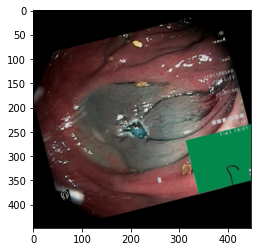

<Figure size 432x288 with 0 Axes>

In [ ]:
imshow(img1[0])
plt.figure()


# Train the CAM network

In [ ]:
train()

Training started ...
https://app.neptune.ai/ch.kalavritinos/OAA/e/OAA-24
Epoch: [0][100/2117]	LR: 0.00100	train loss 0.2427 (0.3020)	
Epoch: [0][200/2117]	LR: 0.00100	train loss 0.2099 (0.2510)	
Epoch: [0][300/2117]	LR: 0.00100	train loss 0.1191 (0.2287)	
Epoch: [0][400/2117]	LR: 0.00100	train loss 0.1343 (0.2107)	
Epoch: [0][500/2117]	LR: 0.00100	train loss 0.1949 (0.1970)	
